In [99]:
import glob

import numpy as np
import matplotlib.pyplot as plt
import astropy.time
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.net import Fido, attrs
from sunpy.time import TimeRange
from sunpy.map import Map
import sunpy.io.fits

%matplotlib inline

# Analyzing AIA Data with sunpy and aiapy
## LMSAL Python Club — 10 October 2019

All materials related to this tutorial are available at [github.com/wtbarnes/lmsal-sunpy-tutorial](https://github.com/wtbarnes/lmsal-sunpy-tutorial). There are several helpful references listed [here](https://github.com/wtbarnes/lmsal-sunpy-tutorial/blob/master/README.md#resources).

In this tutorial, we'll cover the basic capabilities in `sunpy` for downloading, reading, and manipulating 2D image data. We'll then use the `aiapy` package to do some AIA-specific operations on these images.

## Querying Data

In [2]:
q = Fido.search(
    attrs.Time(TimeRange(astropy.time.Time('2010-09-29T23:51:36'), 12*u.h)),
    attrs.Instrument('AIA'),
    attrs.Sample(4*u.h),
    attrs.Wavelength(171*u.angstrom),
)

In [3]:
q

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2010-09-29 23:51:36,2010-09-29 23:51:37,SDO,AIA,FULLDISK,171.0 .. 171.0
2010-09-30 11:51:36,2010-09-30 11:51:37,SDO,AIA,FULLDISK,171.0 .. 171.0
2010-09-30 03:51:36,2010-09-30 03:51:37,SDO,AIA,FULLDISK,171.0 .. 171.0
2010-09-30 07:51:36,2010-09-30 07:51:37,SDO,AIA,FULLDISK,171.0 .. 171.0


In [4]:
files = Fido.fetch(q)

Files Downloaded: 100%|██████████| 4/4 [00:02<00:00,  1.92file/s]


**NOTE:** If you're on a machine where the "SUMS" directories can be resolved locally (e.g. LMSAL, Stanford), see [this notebook](advanced/querying-drms.ipynb).

In [5]:
# If the download is slow/not working, just grab them locally
#files = glob.glob('data/aia_lev1_171a_2010_09*.fits')

In [6]:
files = sorted(files)

In [7]:
files

['/Users/willbarnes/sunpy/data/aia_lev1_171a_2010_09_29t23_51_36_34z_image_lev1.fits',
 '/Users/willbarnes/sunpy/data/aia_lev1_171a_2010_09_30t03_51_36_34z_image_lev1.fits',
 '/Users/willbarnes/sunpy/data/aia_lev1_171a_2010_09_30t07_51_36_34z_image_lev1.fits',
 '/Users/willbarnes/sunpy/data/aia_lev1_171a_2010_09_30t11_51_36_34z_image_lev1.fits']

## The `Map` Object

### Constructing a `Map`

To read in data from an AIA FITS file, we can simply pass the name of the file to the `Map` object.

In [8]:
m = Map(files[0])

The `Map` object looks at header and recognizes it as an AIA observation.

In [9]:
m

SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 171.0 Angstrom
Wavelength:		 171.0 Angstrom
Observation Date:	 2010-09-29 23:51:36
Exposure Time:		 2.000175 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.599489 0.599489] arcsec / pix
Reference Pixel:	 [2051.120117 2048.379883] pix
Reference Coord:	 [0. 0.] arcsec
array([[ 0,  1,  0, ..., -2,  1,  0],
       [ 1, -1,  1, ...,  0, -2, -1],
       [-1,  0, -1, ...,  1, -1, -2],
       ...,
       [ 1,  0,  1, ..., -1, -1,  0],
       [-1, -1, -1, ...,  0,  1, -2],
       [-1,  0, -1, ...,  1, -1, -2]], dtype=int16)

Let's take a quick look at the data to make sure we've read in the right image.

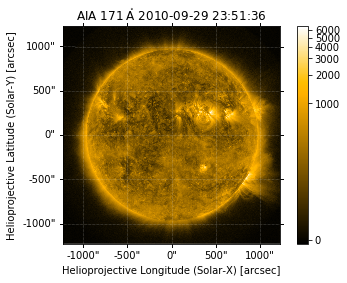

In [10]:
m.peek()

There are many different ways to construct a `Map`. For example, we can read the data in by hand and then pass the header and image data to `Map`.

In [11]:
_,(data,header) = sunpy.io.fits.read(files[0],)

In [12]:
m = Map(data,header)

This is convenient when we want to modify the data or metadata in some way and then construct a new map from the modified data or metadata.

**NOTE:** When loading in or visualizing an image, `Map` is **not** manipulating the data, e.g. it is not being derotated, processed to level 1.5, reprojected, or being normalized in any way. These operations must be applied *explicitly*.

In [13]:
m.data

array([[ 0,  1,  0, ..., -2,  1,  0],
       [ 1, -1,  1, ...,  0, -2, -1],
       [-1,  0, -1, ...,  1, -1, -2],
       ...,
       [ 1,  0,  1, ..., -1, -1,  0],
       [-1, -1, -1, ...,  0,  1, -2],
       [-1,  0, -1, ...,  1, -1, -2]], dtype=int16)

In [14]:
m.data[2000,2000]

252

In [15]:
m.data[:,3000]

array([ 4,  8,  6, ...,  8,  5, 11], dtype=int16)

In [16]:
m.meta

MetaDict([('xtension', 'IMAGE'),
          ('bitpix', 16),
          ('naxis', 2),
          ('naxis1', 4096),
          ('naxis2', 4096),
          ('pcount', 0),
          ('gcount', 1),
          ('bld_vers', 'V5R12X'),
          ('lvl_num', 1.0),
          ('t_rec', '2010-09-29T23:51:37Z'),
          ('trecstep', 1.0),
          ('trecepoc', '1977.01.01_00:00:00_TAI'),
          ('trecroun', 1),
          ('origin', 'SDO/JSOC-SDP'),
          ('date', '2012-10-11T14:03:06'),
          ('telescop', 'SDO/AIA'),
          ('instrume', 'AIA_3'),
          ('date-obs', '2010-09-29T23:51:36.34'),
          ('t_obs', '2010-09-29T23:51:37.34Z'),
          ('camera', 3),
          ('img_type', 'LIGHT'),
          ('exptime', 2.000175),
          ('expsdev', 0.000135),
          ('int_time', 2.273438),
          ('wavelnth', 171),
          ('waveunit', 'angstrom'),
          ('wave_str', '171_THIN'),
          ('fsn', 12898474),
          ('fid', 0),
          ('quallev0', 0),
          ('q

However, we do not need to search through the many header keywords to get useful information about our image. The `Map` object exposes many of these as attributes which can be accessed via the `.` operator.

In [62]:
m.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.0  0.0  
CRPIX : 2051.120117  2048.379883  
PC1_1 PC1_2  : 0.9999999429780868  -0.00033770375054954473  
PC2_1 PC2_2  : 0.00033770375054954473  0.9999999429780868  
CDELT : 0.599489  0.599489  
NAXIS : 0  0

In [63]:
m.dimensions

PixelPair(x=<Quantity 4096. pix>, y=<Quantity 4096. pix>)

In [64]:
m.exposure_time

<Quantity 2.000175 s>

In [65]:
m.scale

SpatialPair(axis1=<Quantity 0.599489 arcsec / pix>, axis2=<Quantity 0.599489 arcsec / pix>)

In [22]:
m.wavelength

<Quantity 171. Angstrom>

**NOTE:** In a Jupyter notebook, if you type `m.` and then press the the tab key, you will be presented with a list of all the attributes and methods available for `Map`.

## Units

In `sunpy`, all inputs and outputs that represent physical quantities must have units atteched to them, i.e. they must be represented as an `astropy.units.Quantity` object (data + unit).

In [28]:
m.wavelength.unit

Unit("Angstrom")

In [29]:
m.wavelength.value

171.0

In [30]:
10 * u.m / (5 * u.s)

<Quantity 2. m / s>

In [31]:
1 * u.h + 2 * u.minute

<Quantity 1.01666667 h>

In [32]:
(1 * u.h + 2 * u.minute).to(u.s)

<Quantity 3660. s>

Attaching units to everything prevents you from making silly mistakes! (This should not work)

In [35]:
1 * u.erg + 34 * u.s

UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

You can even construct quantities from "imperial" units

In [38]:
24 * u.imperial.inch / u.minute + 25 * u.mm / u.s

<Quantity 83.05511811 inch / min>

All of this functionality extends to arrays as well. Any$^*$ operation you can do with a NumPy array, you can do with a `Quantity`.

$*$ Not every NumPy function will preserve the units on a quantity and some may complain about them. If that is the case, you can always get the raw values (with `.value`) and add units on after returning the result.

In [48]:
v = np.random.rand(10) * u.cm / u.s
v

<Quantity [0.18965718, 0.77444293, 0.73954272, 0.07972185, 0.13300194,
           0.95597413, 0.12644015, 0.72402528, 0.93214094, 0.63555451] cm / s>

In [49]:
v * u.Quantity(0.1, 's')

<Quantity [0.01896572, 0.07744429, 0.07395427, 0.00797218, 0.01330019,
           0.09559741, 0.01264401, 0.07240253, 0.09321409, 0.06355545] cm>

## Image Manipulation

### Resampling

Choose a new resolution for the map

In [86]:
new_res = 30 * u.arcsec / u.pixel

Use the existing dimensions and

In [87]:
dim_x = m.dimensions.x * m.scale.axis1 / new_res
dim_y = m.dimensions.y * m.scale.axis2 / new_res
new_dimensions = u.Quantity([dim_x,dim_y])

In [88]:
m_resample = m.resample(new_dimensions)

In [89]:
m_resample.scale

SpatialPair(axis1=<Quantity 30. arcsec / pix>, axis2=<Quantity 30. arcsec / pix>)

In [90]:
m_resample.dimensions

PixelPair(x=<Quantity 82. pix>, y=<Quantity 82. pix>)

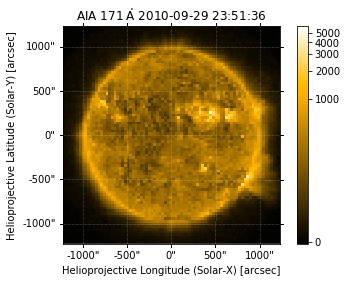

In [91]:
m_resample.peek()

### Rotating

In [94]:
m.rotation_matrix

array([[ 9.99999943e-01, -3.37703751e-04],
       [ 3.37703751e-04,  9.99999943e-01]])

In [92]:
m_rot = m.rotate(angle=45*u.degree)

In [93]:
m_rot.rotation_matrix

array([[ 0.70734553,  0.70686795],
       [-0.70686795,  0.70734553]])

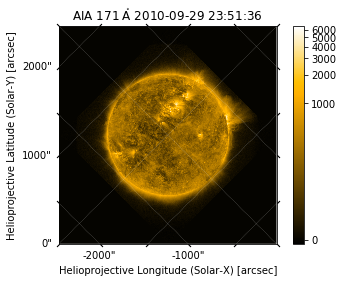

In [95]:
m_rot.peek()

### Cropping

In [55]:
m_sub = m.submap(
    SkyCoord(150*u.arcsec, 50*u.arcsec, frame=m.coordinate_frame),
    SkyCoord(550*u.arcsec, 450*u.arcsec, frame=m.coordinate_frame),
)

In [57]:
m_sub.dimensions

PixelPair(x=<Quantity 667. pix>, y=<Quantity 667. pix>)

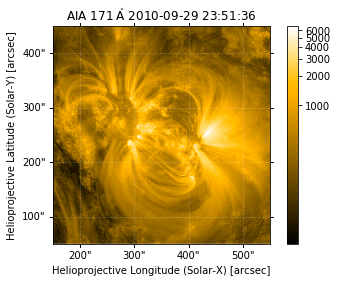

In [56]:
m_sub.peek()

In [101]:
m_sub.bottom_left_coord

<SkyCoord (Helioprojective: obstime=2010-09-29T23:51:36.340, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (-0.00928619, 6.7887263, 1.49827386e+11)>): (Tx, Ty) in arcsec
    (150.38276609, 50.18011369)>

In [100]:
m_sub.top_right_coord

<SkyCoord (Helioprojective: obstime=2010-09-29T23:51:36.340, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (-0.00928619, 6.7887263, 1.49827386e+11)>): (Tx, Ty) in arcsec
    (550.10559473, 450.17198638)>

### Differential Rotation
**NOTE:** Currently broken for submaps.

## Coordinates

Use of `world_to_pixel` for finding correspondence between pixel and world coordinates (and vice versa)

In [21]:
m.coordinate_frame

<Helioprojective Frame (obstime=2010-09-29T23:51:36.340, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (-0.00928619, 6.7887263, 1.49827386e+11)>)>

In [20]:
m.center

<SkyCoord (Helioprojective: obstime=2010-09-29T23:51:36.340, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (-0.00928619, 6.7887263, 1.49827386e+11)>): (Tx, Ty) in arcsec
    (-1.27111229, 0.37132408)>

In [26]:
m.center.transform_to('heliographic_carrington')

<SkyCoord (HeliographicCarrington: obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (41.27462156, 6.81082128, 6.96e+08)>

In [24]:
m.bottom_left_coord

<SkyCoord (Helioprojective: obstime=2010-09-29T23:51:36.340, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (-0.00928619, 6.7887263, 1.49827386e+11)>): (Tx, Ty) in arcsec
    (-1228.59536747, -1227.76041437)>

In [23]:
m.top_right_coord

<SkyCoord (Helioprojective: obstime=2010-09-29T23:51:36.340, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (-0.00928619, 6.7887263, 1.49827386e+11)>): (Tx, Ty) in arcsec
    (1226.0532329, 1228.50311312)>

For several examples of the power of the coordinates stack, see the following examples:

* [Modeling Coronal Loops in 3D](advanced/projecting-coronal-loops.ipynb)
* [Plotting Fieldlines from a PFSS Extrapolation](advanced/pfss-fieldlines.ipynb)

Other coordinate examples external to this tutorial:

* [Overplotting HEK Features (from the sunpy example gallery)](http://docs.sunpy.org/en/stable/generated/gallery/plotting/overplot_hek_polygon.html#sphx-glr-generated-gallery-plotting-overplot-hek-polygon-py)
* [Overplotting AIA/EUVI Coordinates](https://github.com/sunpy/tutorial-notebooks/blob/master/2019_spd/sunpy-1.0-spd2019-coordinates.ipynb)

## Visualization

* Basic plotting beyond `.peek`
* Drawing rectangles
* Grids
* Plotting pixel coords with w2p
* Changing the colormap (some explanation of underlying matplotlib commands)
* Changing tick labels and axis labels
* Masking

As we've shown above the `.peek` command provides an easy way to quickly visualize our map.

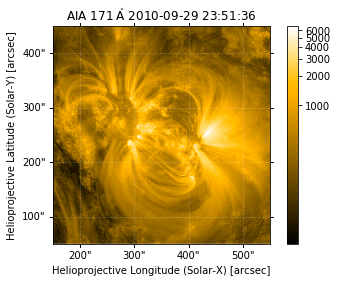

In [97]:
m_sub.peek()

Note that `.peek` gives us coordinate-aware axes as well as the standard AIA 171 colormap. This is all very nice, but does not give us much control over how the plot looks. This can be a problem, particularly when preparing figures for publication.

To customize the look of our plots, we can leverage all of the great features in [matplotlib](https://matplotlib.org/) to customize our plots. If we just plot our image using the standard `imshow` command in matplotlib,

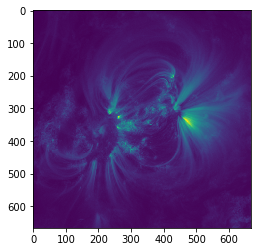

In [102]:
fig = plt.figure()
ax = fig.gca()
ax.imshow(m_sub.data)

Note that this gives us axes in pixel coordinates and image flipped upside down. Fortunately, `Map` provides the `plot` command which is a wrapper around the `imshow`.

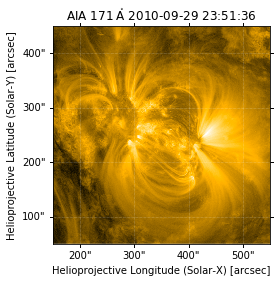

In [103]:
fig = plt.figure()
ax = fig.gca(projection=m_sub)
m_sub.plot(axes=ax)

All of the plotting capabilities provided by sunpy/astropy are built on top of matplotlib so any desired customizations can be done using matplotlib. The additional coordinate-aware axes support is provided by the astropy-affiliated [wcsaxes](https://wcsaxes.readthedocs.io/en/latest/) package.

Also, see the [advanced plotting examples](advanced/plotting.ipynb) for some more complicated plots.

## `aiapy`: A Python Package for Analyzing AIA Data

### Data "Prep"

### Image Degradation

### Wavelength Response Functions